In [1]:
# Importing all the required Libraries for Model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Conv2D,MaxPooling2D, Dense, Dropout, Flatten, BatchNormalization,Activation, GlobalAveragePooling2D

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras import Model
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
import cv2
import os

# Removing all those annoying Warnings

import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
import zipfile

zip_path = "/content/drive/MyDrive/fer2013.zip"  # change if your name differs
extract_path = "/content/dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [6]:
# Define dataset paths
train_path = "/content/dataset/train"
test_path = "/content/dataset/test"


In [7]:
#list the directory of test path
os.listdir(test_path)

['surprise', 'angry', 'happy', 'neutral', 'disgust', 'sad', 'fear']

In [8]:
#list the directory of trian path
os.listdir(train_path)

['surprise', 'angry', 'happy', 'neutral', 'disgust', 'sad', 'fear']

In [9]:
#getting the first image of angry folder
os.listdir(train_path + '/angry')[0]


'Training_52927331.jpg'

In [11]:
import os
img = os.path.join(train_path, 'angry', 'Training_52927331.jpg')


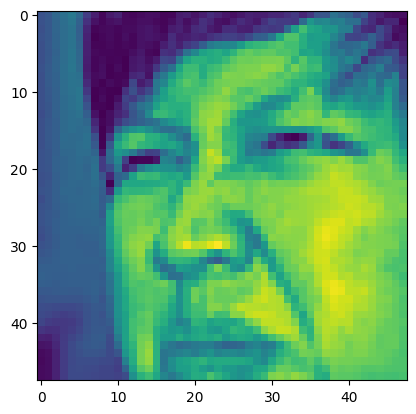

In [12]:
#showing the first image of angry folder
plt.imshow(imread(img))

In [13]:
#define a function to plot some images from different classes

def plot_images(img_dir, top=10):
    all_img_dirs = os.listdir(img_dir)
    img_files = [os.path.join(img_dir, file) for file in all_img_dirs][:5]

    plt.figure(figsize=(10, 10))

    for idx, img_path in enumerate(img_files):
        plt.subplot(5, 5, idx+1)

        img = plt.imread(img_path)
        plt.tight_layout()
        plt.imshow(img, cmap='gray')

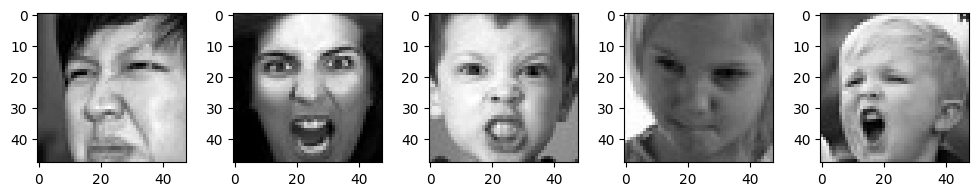

In [14]:
#sample of angry class
plot_images(train_path+'/angry')

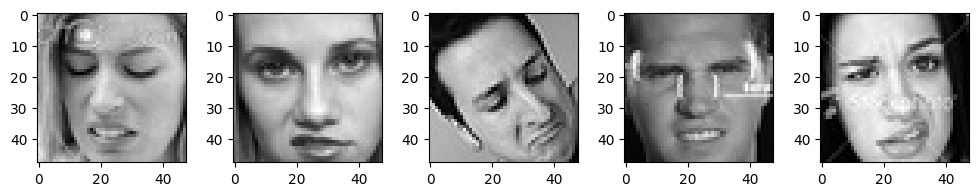

In [15]:
#sample of disgust class
plot_images(train_path+'/disgust')

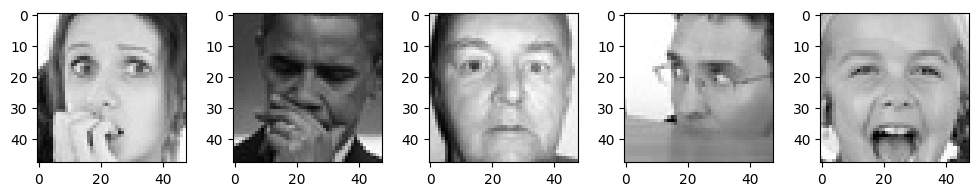

In [16]:
#sample of fear class
plot_images(train_path+'/fear')

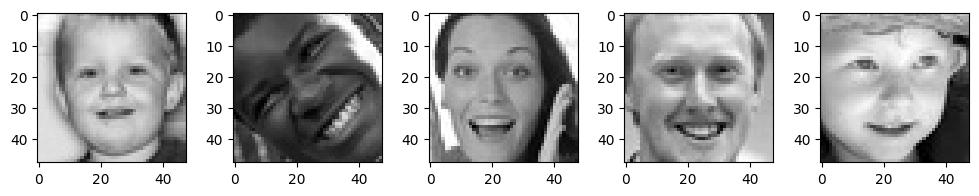

In [17]:
#sample of happy class
plot_images(train_path+'/happy')

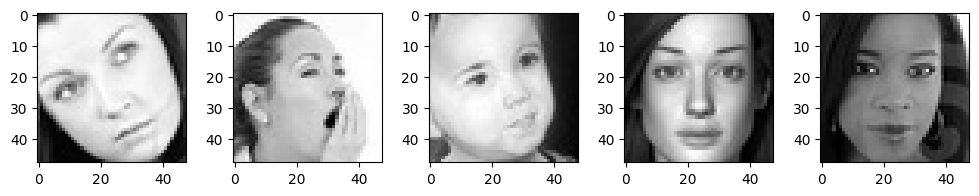

In [18]:
#sample of neutral class
plot_images(train_path+'/neutral')

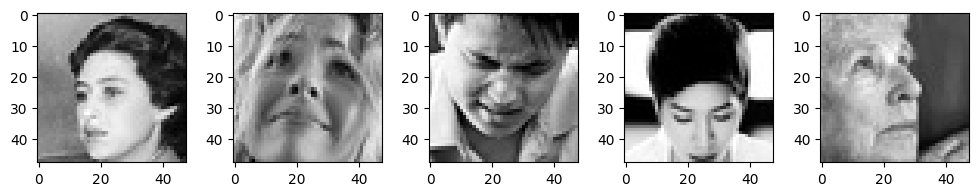

In [19]:
#sample of sad class
plot_images(train_path+'/sad')

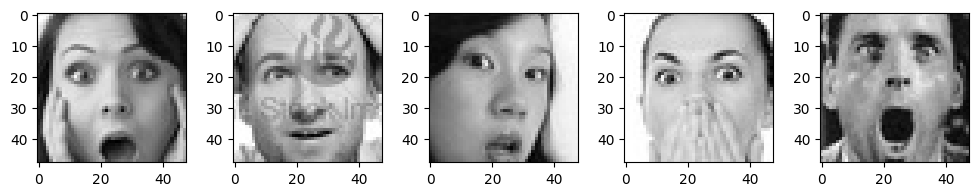

In [20]:
#sample of surprise class
plot_images(train_path+'/surprise')

In [21]:
for expression in os.listdir(train_path):
    print(str(len(os.listdir(train_path + '/' + expression))) + " " + expression + " images")


3171 surprise images
3995 angry images
7215 happy images
4965 neutral images
436 disgust images
4830 sad images
4097 fear images


In [23]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Training data generator WITH augmentation + validation split
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.15,
    height_shift_range=0.15,
    zoom_range=0.2,
    shear_range=0.1,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    fill_mode='reflect',
    validation_split=0.2  # 20% of training data for validation
)

# Testing generator (no augmentation)
test_datagen = ImageDataGenerator(rescale=1./255)

In [24]:
# Parameters
IMG_SIZE = (48, 48)
BATCH_SIZE = 64

# Training subset
train_gen = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset='training',
    shuffle=True
)

# Validation subset
val_gen = train_datagen.flow_from_directory(
    train_path,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    subset='validation',
    shuffle=True
)

# Test set (no augmentation)
test_gen = test_datagen.flow_from_directory(
    test_path,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Check dataset sizes
print(f"✅ Train samples: {train_gen.samples}")
print(f"✅ Validation samples: {val_gen.samples}")
print(f"✅ Test samples: {test_gen.samples}")

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
✅ Train samples: 22968
✅ Validation samples: 5741
✅ Test samples: 7178


✅ Class label mapping: {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
✅ Computed Class Weights: {0: np.float32(1.0266404), 1: np.float32(9.401555), 2: np.float32(1.0009588), 3: np.float32(0.56845856), 4: np.float32(0.82606816), 5: np.float32(0.84915704), 6: np.float32(1.293316)}


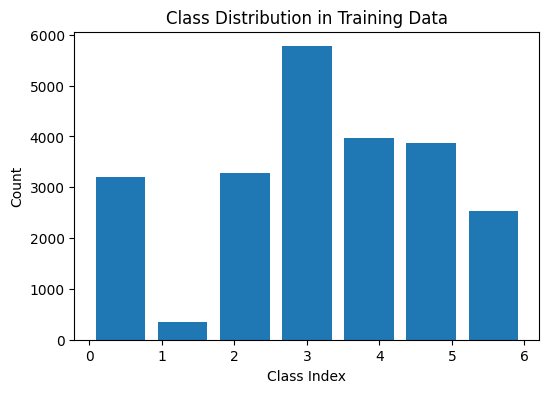

In [25]:
# ==========================================================
# ✅ Compute Class Weights for Imbalanced FER-13 Dataset
# ==========================================================

from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import matplotlib.pyplot as plt

# Get class labels (integer indices for each image)
class_labels = train_gen.classes
class_indices = train_gen.class_indices

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
).astype(np.float32)

# Convert to dictionary {class_index: weight_value}
class_weights_dict = dict(enumerate(class_weights))

# Print class mapping and weights
print("✅ Class label mapping:", class_indices)
print("✅ Computed Class Weights:", class_weights_dict)

# Optional: visualize imbalance (for understanding)
plt.figure(figsize=(6,4))
plt.hist(class_labels, bins=len(class_indices), rwidth=0.8)
plt.title("Class Distribution in Training Data")
plt.xlabel("Class Index")
plt.ylabel("Count")
plt.show()


In [26]:
#printing the class indicies og train_gen
print(train_gen.class_indices)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


Image pixel range: min=0.000, max=1.000


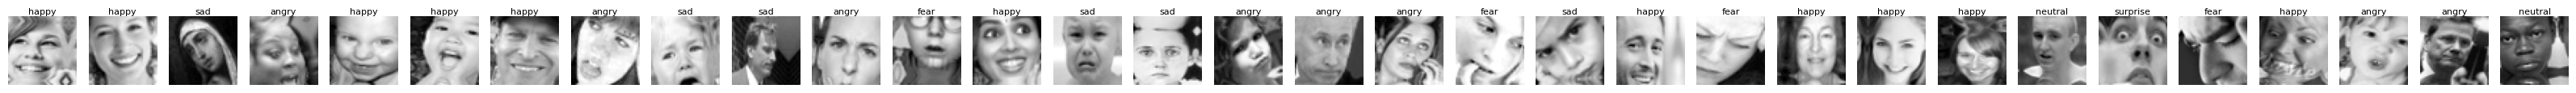

In [27]:
# ==========================================================
# ✅ Visualize a Batch of Training Images with Labels
# ==========================================================

# Get one random batch from training generator
imgs, labels = next(train_gen)

# Define class names (must match your dataset order)
class_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Confirm normalization (should be in range 0–1)
print(f"Image pixel range: min={imgs.min():.3f}, max={imgs.max():.3f}")

# Visualization function
def plotImages(images_arr, labels_arr, class_names):
    n = len(images_arr)
    fig, axes = plt.subplots(1, n, figsize=(n, 2))
    axes = np.ravel(axes)

    for i in range(n):
        img = images_arr[i].squeeze()  # Remove channel dimension if grayscale
        label_index = np.argmax(labels_arr[i])
        label_name = class_names[label_index]
        axes[i].imshow(img, cmap='gray')
        axes[i].set_title(label_name, fontsize=8, pad=2)
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()

# Plot up to 32 images (or fewer if batch smaller)
plotImages(imgs[:32], labels[:32], class_names)


In [28]:
# ==========================================================
# ✅ Optimized CNN Architecture for FER-13 (from scratch)
# ==========================================================
from tensorflow.keras.regularizers import l2

no_of_classes = 7

model = Sequential([
    # Block 1
    Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal',
           kernel_regularizer=l2(1e-4), input_shape=(48,48,1)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (3,3), padding='same', kernel_initializer='he_normal',
           kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    # Block 2
    Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.3),

    # Block 3
    Conv2D(256, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(256, (3,3), padding='same', kernel_initializer='he_normal', kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.4),

    # Global Pooling instead of Flatten
    GlobalAveragePooling2D(),

    # Dense layers
    Dense(256, kernel_regularizer=l2(1e-4)),
    BatchNormalization(),
    Activation('relu'),
    Dropout(0.5),

    # Output layer
    Dense(no_of_classes, activation='softmax')
])

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 12, 12, 256)    │             

 Total params: 1,216,455 (4.64 MB)

 Trainable params: 1,214,151 (4.63 MB)

 Non-trainable params: 2,304 (9.00 KB)

In [29]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import losses, metrics

# ✅ Compile the model with improved loss and metrics
model.compile(
    optimizer=Adam(learning_rate=1e-3),
    loss=losses.CategoricalCrossentropy(label_smoothing=0.05),
    metrics=[
        'accuracy',
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall')
    ]
)



In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

# ==========================================================
# ✅ Callbacks for FER-13 Training
# ==========================================================

# Save the best model based on validation loss
checkpoint = ModelCheckpoint(
    filepath='best_fer13_cnn.h5',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min'
)

# Stop training if no improvement in validation loss for 10 epochs
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)

# Reduce LR when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,       # reduce LR by half
    patience=4,       # wait 4 epochs before reducing
    verbose=1,
    min_lr=1e-6
)

# Optional: Log training progress to a CSV file
csv_logger = CSVLogger('training_log.csv', append=True)

# Combine all callbacks
callbacks = [checkpoint, early_stopping, reduce_lr, csv_logger]


In [31]:
# ==========================================================
# ✅ Train the Model (Optimized Configuration)
# ==========================================================

history = model.fit(
    train_gen,
    validation_data=val_gen,            # <-- Use validation split instead of test set
    epochs=60,
    callbacks=callbacks,
    class_weight=class_weights_dict,
    verbose=1
)


Epoch 1/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - accuracy: 0.1561 - loss: 2.5298 - precision: 0.1504 - recall: 0.0195
Epoch 1: val_loss improved from inf to 2.16280, saving model to best_fer13_cnn.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 64s 126ms/step - accuracy: 0.1561 - loss: 2.5294 - precision: 0.1504 - recall: 0.0195 - val_accuracy: 0.1484 - val_loss: 2.1628 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.1501 - loss: 2.2734 - precision: 0.1608 - recall: 0.0063
Epoch 2: val_loss did not improve from 2.16280
359/359 ━━━━━━━━━━━━━━━━━━━━ 30s 83ms/step - accuracy: 0.1502 - loss: 2.2733 - precision: 0.1608 - recall: 0.0063 - val_accuracy: 0.1568 - val_loss: 2.2739 - val_precision: 0.2210 - val_recall: 0.0488 - learning_rate: 0.0010
Epoch 3/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.1591 - loss: 2.1633 - precision: 0.2257 - recall: 0.0052
Epoch 3: val_loss improved from 2.16280 to 2.09856, saving model to best_fer13_cnn.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 31s 85ms/step - accuracy: 0.1591 - loss: 2.1632 - precision: 0.2257 - recall: 0.0052 - val_accuracy: 0.1818 - val_loss: 2.0986 - val_precision: 0.3874 - val_recall: 0.0129 - learning_rate: 0.0010
Epoch 4/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.1809 - loss: 2.0945 - precision: 0.3325 - recall: 0.0068
Epoch 4: val_loss improved from 2.09856 to 1.99223, saving model to best_fer13_cnn.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 31s 87ms/step - accuracy: 0.1809 - loss: 2.0944 - precision: 0.3328 - recall: 0.0068 - val_accuracy: 0.2627 - val_loss: 1.9922 - val_precision: 1.0000 - val_recall: 3.4837e-04 - learning_rate: 0.0010
Epoch 5/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.2115 - loss: 1.9953 - precision: 0.4964 - recall: 0.0265
Epoch 5: val_loss did not improve from 1.99223
359/359 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.2115 - loss: 1.9952 - precision: 0.4965 - recall: 0.0265 - val_accuracy: 0.2010 - val_loss: 2.3055 - val_precision: 0.2571 - val_recall: 0.0824 - learning_rate: 0.0010
Epoch 6/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.2402 - loss: 1.9495 - precision: 0.5603 - recall: 0.0369
Epoch 6: val_loss did not improve from 1.99223
359/359 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.2402 - loss: 1.9494 - precision: 0.5603 - recall: 0.0369 - val_accuracy: 0.2682 - val_loss: 2.0097 - val_precision: 0.4565 - val_recall: 0.0512 - l

359/359 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.2755 - loss: 1.9018 - precision: 0.5633 - recall: 0.0478 - val_accuracy: 0.2573 - val_loss: 1.9415 - val_precision: 0.5154 - val_recall: 0.0669 - learning_rate: 0.0010
Epoch 8/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3058 - loss: 1.8674 - precision: 0.5624 - recall: 0.0580
Epoch 8: val_loss improved from 1.94146 to 1.86309, saving model to best_fer13_cnn.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 31s 86ms/step - accuracy: 0.3058 - loss: 1.8673 - precision: 0.5624 - recall: 0.0580 - val_accuracy: 0.2919 - val_loss: 1.8631 - val_precision: 0.6005 - val_recall: 0.0442 - learning_rate: 0.0010
Epoch 9/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.3450 - loss: 1.8015 - precision: 0.6452 - recall: 0.0952
Epoch 9: val_loss did not improve from 1.86309
359/359 ━━━━━━━━━━━━━━━━━━━━ 30s 85ms/step - accuracy: 0.3450 - loss: 1.8015 - precision: 0.6453 - recall: 0.0952 - val_accuracy: 0.3318 - val_loss: 1.9843 - val_precision: 0.6820 - val_recall: 0.0568 - learning_rate: 0.0010
Epoch 10/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.3895 - loss: 1.7459 - precision: 0.6722 - recall: 0.1330
Epoch 10: val_loss improved from 1.86309 to 1.85434, saving model to best_fer13_cnn.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 31s 85ms/step - accuracy: 0.3895 - loss: 1.7459 - precision: 0.6722 - recall: 0.1330 - val_accuracy: 0.3982 - val_loss: 1.8543 - val_precision: 0.5323 - val_recall: 0.2587 - learning_rate: 0.0010
Epoch 11/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4067 - loss: 1.7183 - precision: 0.6810 - recall: 0.1533
Epoch 11: val_loss improved from 1.85434 to 1.79215, saving model to best_fer13_cnn.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 31s 85ms/step - accuracy: 0.4067 - loss: 1.7183 - precision: 0.6810 - recall: 0.1534 - val_accuracy: 0.3876 - val_loss: 1.7921 - val_precision: 0.6419 - val_recall: 0.1839 - learning_rate: 0.0010
Epoch 12/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4299 - loss: 1.6838 - precision: 0.7087 - recall: 0.1767
Epoch 12: val_loss did not improve from 1.79215
359/359 ━━━━━━━━━━━━━━━━━━━━ 31s 86ms/step - accuracy: 0.4299 - loss: 1.6838 - precision: 0.7086 - recall: 0.1767 - val_accuracy: 0.2851 - val_loss: 2.1564 - val_precision: 0.3320 - val_recall: 0.1892 - learning_rate: 0.0010
Epoch 13/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.4432 - loss: 1.6524 - precision: 0.7052 - recall: 0.1943
Epoch 13: val_loss improved from 1.79215 to 1.76486, saving model to best_fer13_cnn.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.4432 - loss: 1.6524 - precision: 0.7052 - recall: 0.1943 - val_accuracy: 0.4045 - val_loss: 1.7649 - val_precision: 0.5738 - val_recall: 0.2120 - learning_rate: 0.0010
Epoch 14/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4522 - loss: 1.6335 - precision: 0.7162 - recall: 0.2008
Epoch 14: val_loss did not improve from 1.76486
359/359 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.4522 - loss: 1.6335 - precision: 0.7162 - recall: 0.2008 - val_accuracy: 0.3022 - val_loss: 2.0347 - val_precision: 0.5305 - val_recall: 0.1061 - learning_rate: 0.0010
Epoch 15/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4566 - loss: 1.6414 - precision: 0.7219 - recall: 0.2102
Epoch 15: val_loss did not improve from 1.76486
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 99ms/step - accuracy: 0.4566 - loss: 1.6413 - precision: 0.7219 - recall: 0.2103 - val_accuracy: 0.2846 - val_loss: 2.0910 - val_precision: 0.3563 - val_recall: 0.1583 - l

359/359 ━━━━━━━━━━━━━━━━━━━━ 30s 85ms/step - accuracy: 0.4685 - loss: 1.6264 - precision: 0.7050 - recall: 0.2289 - val_accuracy: 0.4367 - val_loss: 1.7299 - val_precision: 0.5519 - val_recall: 0.3168 - learning_rate: 0.0010
Epoch 17/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.4742 - loss: 1.5996 - precision: 0.7198 - recall: 0.2279
Epoch 17: val_loss improved from 1.72991 to 1.63422, saving model to best_fer13_cnn.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 31s 86ms/step - accuracy: 0.4742 - loss: 1.5996 - precision: 0.7198 - recall: 0.2280 - val_accuracy: 0.4651 - val_loss: 1.6342 - val_precision: 0.7125 - val_recall: 0.2284 - learning_rate: 0.0010
Epoch 18/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - accuracy: 0.4853 - loss: 1.6133 - precision: 0.7303 - recall: 0.2457
Epoch 18: val_loss did not improve from 1.63422
359/359 ━━━━━━━━━━━━━━━━━━━━ 31s 85ms/step - accuracy: 0.4853 - loss: 1.6133 - precision: 0.7303 - recall: 0.2457 - val_accuracy: 0.4262 - val_loss: 1.8066 - val_precision: 0.5608 - val_recall: 0.2378 - learning_rate: 0.0010
Epoch 19/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4872 - loss: 1.5921 - precision: 0.7219 - recall: 0.2507
Epoch 19: val_loss improved from 1.63422 to 1.51836, saving model to best_fer13_cnn.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 31s 86ms/step - accuracy: 0.4872 - loss: 1.5921 - precision: 0.7219 - recall: 0.2507 - val_accuracy: 0.5215 - val_loss: 1.5184 - val_precision: 0.7454 - val_recall: 0.3116 - learning_rate: 0.0010
Epoch 20/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.4936 - loss: 1.5951 - precision: 0.7298 - recall: 0.2595
Epoch 20: val_loss did not improve from 1.51836
359/359 ━━━━━━━━━━━━━━━━━━━━ 31s 87ms/step - accuracy: 0.4936 - loss: 1.5950 - precision: 0.7298 - recall: 0.2595 - val_accuracy: 0.4888 - val_loss: 1.6004 - val_precision: 0.6620 - val_recall: 0.3459 - learning_rate: 0.0010
Epoch 21/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.4976 - loss: 1.5678 - precision: 0.7172 - recall: 0.2646
Epoch 21: val_loss did not improve from 1.51836
359/359 ━━━━━━━━━━━━━━━━━━━━ 46s 100ms/step - accuracy: 0.4976 - loss: 1.5678 - precision: 0.7172 - recall: 0.2646 - val_accuracy: 0.3569 - val_loss: 2.0178 - val_precision: 0.4637 - val_recall: 0.1890 - 

359/359 ━━━━━━━━━━━━━━━━━━━━ 31s 87ms/step - accuracy: 0.5257 - loss: 1.5047 - precision: 0.7346 - recall: 0.2922 - val_accuracy: 0.5433 - val_loss: 1.4752 - val_precision: 0.7110 - val_recall: 0.3586 - learning_rate: 5.0000e-04
Epoch 25/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5329 - loss: 1.4683 - precision: 0.7437 - recall: 0.3163
Epoch 25: val_loss did not improve from 1.47520
359/359 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.5330 - loss: 1.4683 - precision: 0.7437 - recall: 0.3163 - val_accuracy: 0.5074 - val_loss: 1.5419 - val_precision: 0.6515 - val_recall: 0.3843 - learning_rate: 5.0000e-04
Epoch 26/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5469 - loss: 1.4532 - precision: 0.7461 - recall: 0.3243
Epoch 26: val_loss improved from 1.47520 to 1.45494, saving model to best_fer13_cnn.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 30s 85ms/step - accuracy: 0.5469 - loss: 1.4531 - precision: 0.7461 - recall: 0.3243 - val_accuracy: 0.5485 - val_loss: 1.4549 - val_precision: 0.7730 - val_recall: 0.3073 - learning_rate: 5.0000e-04
Epoch 27/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5443 - loss: 1.4341 - precision: 0.7511 - recall: 0.3295
Epoch 27: val_loss improved from 1.45494 to 1.43351, saving model to best_fer13_cnn.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 32s 89ms/step - accuracy: 0.5443 - loss: 1.4341 - precision: 0.7511 - recall: 0.3295 - val_accuracy: 0.5544 - val_loss: 1.4335 - val_precision: 0.7950 - val_recall: 0.3121 - learning_rate: 5.0000e-04
Epoch 28/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.5580 - loss: 1.4063 - precision: 0.7579 - recall: 0.3366
Epoch 28: val_loss did not improve from 1.43351
359/359 ━━━━━━━━━━━━━━━━━━━━ 31s 86ms/step - accuracy: 0.5579 - loss: 1.4063 - precision: 0.7579 - recall: 0.3366 - val_accuracy: 0.4536 - val_loss: 1.7215 - val_precision: 0.5673 - val_recall: 0.3069 - learning_rate: 5.0000e-04
Epoch 29/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5514 - loss: 1.3885 - precision: 0.7580 - recall: 0.3330
Epoch 29: val_loss improved from 1.43351 to 1.37788, saving model to best_fer13_cnn.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 30s 85ms/step - accuracy: 0.5514 - loss: 1.3885 - precision: 0.7580 - recall: 0.3330 - val_accuracy: 0.5760 - val_loss: 1.3779 - val_precision: 0.7528 - val_recall: 0.3957 - learning_rate: 5.0000e-04
Epoch 30/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5546 - loss: 1.4232 - precision: 0.7473 - recall: 0.3329
Epoch 30: val_loss did not improve from 1.37788
359/359 ━━━━━━━━━━━━━━━━━━━━ 35s 99ms/step - accuracy: 0.5546 - loss: 1.4232 - precision: 0.7473 - recall: 0.3329 - val_accuracy: 0.5557 - val_loss: 1.4379 - val_precision: 0.7314 - val_recall: 0.3628 - learning_rate: 5.0000e-04
Epoch 31/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5591 - loss: 1.3980 - precision: 0.7462 - recall: 0.3406
Epoch 31: val_loss did not improve from 1.37788
359/359 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.5591 - loss: 1.3980 - precision: 0.7463 - recall: 0.3406 - val_accuracy: 0.5725 - val_loss: 1.4011 - val_precision: 0.7375 - val_recall: 0.

359/359 ━━━━━━━━━━━━━━━━━━━━ 32s 89ms/step - accuracy: 0.5881 - loss: 1.3061 - precision: 0.7673 - recall: 0.3873 - val_accuracy: 0.5802 - val_loss: 1.3716 - val_precision: 0.7503 - val_recall: 0.3905 - learning_rate: 2.5000e-04
Epoch 37/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5942 - loss: 1.3158 - precision: 0.7639 - recall: 0.3941
Epoch 37: val_loss did not improve from 1.37163
359/359 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.5942 - loss: 1.3158 - precision: 0.7639 - recall: 0.3941 - val_accuracy: 0.5565 - val_loss: 1.4425 - val_precision: 0.7039 - val_recall: 0.3900 - learning_rate: 2.5000e-04
Epoch 38/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5981 - loss: 1.2959 - precision: 0.7644 - recall: 0.3949
Epoch 38: val_loss improved from 1.37163 to 1.34287, saving model to best_fer13_cnn.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 30s 85ms/step - accuracy: 0.5980 - loss: 1.2959 - precision: 0.7644 - recall: 0.3949 - val_accuracy: 0.5893 - val_loss: 1.3429 - val_precision: 0.7744 - val_recall: 0.3874 - learning_rate: 2.5000e-04
Epoch 39/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5972 - loss: 1.2904 - precision: 0.7563 - recall: 0.3920
Epoch 39: val_loss improved from 1.34287 to 1.33162, saving model to best_fer13_cnn.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 31s 85ms/step - accuracy: 0.5972 - loss: 1.2904 - precision: 0.7563 - recall: 0.3920 - val_accuracy: 0.5954 - val_loss: 1.3316 - val_precision: 0.7777 - val_recall: 0.3973 - learning_rate: 2.5000e-04
Epoch 40/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5935 - loss: 1.2905 - precision: 0.7641 - recall: 0.3967
Epoch 40: val_loss improved from 1.33162 to 1.31795, saving model to best_fer13_cnn.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 32s 88ms/step - accuracy: 0.5935 - loss: 1.2905 - precision: 0.7641 - recall: 0.3967 - val_accuracy: 0.6043 - val_loss: 1.3180 - val_precision: 0.7529 - val_recall: 0.4341 - learning_rate: 2.5000e-04
Epoch 41/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.5986 - loss: 1.2955 - precision: 0.7616 - recall: 0.4076
Epoch 41: val_loss did not improve from 1.31795
359/359 ━━━━━━━━━━━━━━━━━━━━ 30s 84ms/step - accuracy: 0.5986 - loss: 1.2955 - precision: 0.7616 - recall: 0.4076 - val_accuracy: 0.5887 - val_loss: 1.3536 - val_precision: 0.7430 - val_recall: 0.4231 - learning_rate: 2.5000e-04
Epoch 42/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6032 - loss: 1.2818 - precision: 0.7696 - recall: 0.4080
Epoch 42: val_loss did not improve from 1.31795
359/359 ━━━━━━━━━━━━━━━━━━━━ 31s 85ms/step - accuracy: 0.6032 - loss: 1.2818 - precision: 0.7696 - recall: 0.4080 - val_accuracy: 0.5966 - val_loss: 1.3354 - val_precision: 0.7641 - val_recall: 0.

359/359 ━━━━━━━━━━━━━━━━━━━━ 33s 91ms/step - accuracy: 0.6184 - loss: 1.2208 - precision: 0.7745 - recall: 0.4337 - val_accuracy: 0.6067 - val_loss: 1.3009 - val_precision: 0.7459 - val_recall: 0.4443 - learning_rate: 1.2500e-04
Epoch 49/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.6153 - loss: 1.2128 - precision: 0.7757 - recall: 0.4329
Epoch 49: val_loss improved from 1.30092 to 1.29679, saving model to best_fer13_cnn.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 31s 86ms/step - accuracy: 0.6153 - loss: 1.2128 - precision: 0.7757 - recall: 0.4329 - val_accuracy: 0.6043 - val_loss: 1.2968 - val_precision: 0.7599 - val_recall: 0.4327 - learning_rate: 1.2500e-04
Epoch 50/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.6226 - loss: 1.2175 - precision: 0.7784 - recall: 0.4392
Epoch 50: val_loss did not improve from 1.29679
359/359 ━━━━━━━━━━━━━━━━━━━━ 31s 87ms/step - accuracy: 0.6226 - loss: 1.2175 - precision: 0.7784 - recall: 0.4392 - val_accuracy: 0.6011 - val_loss: 1.3029 - val_precision: 0.7363 - val_recall: 0.4562 - learning_rate: 1.2500e-04
Epoch 51/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6218 - loss: 1.2022 - precision: 0.7746 - recall: 0.4454
Epoch 51: val_loss improved from 1.29679 to 1.29117, saving model to best_fer13_cnn.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 32s 89ms/step - accuracy: 0.6218 - loss: 1.2022 - precision: 0.7746 - recall: 0.4454 - val_accuracy: 0.6140 - val_loss: 1.2912 - val_precision: 0.7519 - val_recall: 0.4550 - learning_rate: 1.2500e-04
Epoch 52/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.6231 - loss: 1.2110 - precision: 0.7770 - recall: 0.4419
Epoch 52: val_loss improved from 1.29117 to 1.28872, saving model to best_fer13_cnn.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 33s 91ms/step - accuracy: 0.6231 - loss: 1.2110 - precision: 0.7770 - recall: 0.4419 - val_accuracy: 0.6121 - val_loss: 1.2887 - val_precision: 0.7588 - val_recall: 0.4597 - learning_rate: 1.2500e-04
Epoch 53/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6211 - loss: 1.2128 - precision: 0.7820 - recall: 0.4445
Epoch 53: val_loss did not improve from 1.28872
359/359 ━━━━━━━━━━━━━━━━━━━━ 37s 103ms/step - accuracy: 0.6211 - loss: 1.2128 - precision: 0.7820 - recall: 0.4445 - val_accuracy: 0.6067 - val_loss: 1.2926 - val_precision: 0.7738 - val_recall: 0.4285 - learning_rate: 1.2500e-04
Epoch 54/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6218 - loss: 1.2019 - precision: 0.7804 - recall: 0.4423
Epoch 54: val_loss did not improve from 1.28872
359/359 ━━━━━━━━━━━━━━━━━━━━ 31s 86ms/step - accuracy: 0.6218 - loss: 1.2019 - precision: 0.7804 - recall: 0.4423 - val_accuracy: 0.6093 - val_loss: 1.2901 - val_precision: 0.7538 - val_recall: 0

359/359 ━━━━━━━━━━━━━━━━━━━━ 31s 85ms/step - accuracy: 0.6310 - loss: 1.1983 - precision: 0.7765 - recall: 0.4474 - val_accuracy: 0.6184 - val_loss: 1.2776 - val_precision: 0.7550 - val_recall: 0.4633 - learning_rate: 1.2500e-04
Epoch 57/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6309 - loss: 1.1995 - precision: 0.7875 - recall: 0.4513
Epoch 57: val_loss did not improve from 1.27755
359/359 ━━━━━━━━━━━━━━━━━━━━ 31s 85ms/step - accuracy: 0.6309 - loss: 1.1995 - precision: 0.7875 - recall: 0.4513 - val_accuracy: 0.6105 - val_loss: 1.2830 - val_precision: 0.7552 - val_recall: 0.4578 - learning_rate: 1.2500e-04
Epoch 58/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6266 - loss: 1.1896 - precision: 0.7840 - recall: 0.4522
Epoch 58: val_loss improved from 1.27755 to 1.26472, saving model to best_fer13_cnn.h5


359/359 ━━━━━━━━━━━━━━━━━━━━ 31s 87ms/step - accuracy: 0.6266 - loss: 1.1896 - precision: 0.7840 - recall: 0.4521 - val_accuracy: 0.6194 - val_loss: 1.2647 - val_precision: 0.7571 - val_recall: 0.4642 - learning_rate: 1.2500e-04
Epoch 59/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - accuracy: 0.6282 - loss: 1.1991 - precision: 0.7764 - recall: 0.4485
Epoch 59: val_loss did not improve from 1.26472
359/359 ━━━━━━━━━━━━━━━━━━━━ 31s 86ms/step - accuracy: 0.6282 - loss: 1.1991 - precision: 0.7764 - recall: 0.4485 - val_accuracy: 0.6060 - val_loss: 1.3043 - val_precision: 0.7307 - val_recall: 0.4571 - learning_rate: 1.2500e-04
Epoch 60/60
359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.6329 - loss: 1.1844 - precision: 0.7793 - recall: 0.4563
Epoch 60: val_loss did not improve from 1.26472
359/359 ━━━━━━━━━━━━━━━━━━━━ 32s 89ms/step - accuracy: 0.6329 - loss: 1.1844 - precision: 0.7793 - recall: 0.4563 - val_accuracy: 0.6074 - val_loss: 1.2838 - val_precision: 0.7620 - val_recall: 0.

113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 71ms/step

✅ Final Test Accuracy: 64.70%

📊 Classification Report:
               precision    recall  f1-score   support

       angry       0.49      0.69      0.57       958
     disgust       0.51      0.64      0.57       111
        fear       0.61      0.26      0.36      1024
       happy       0.88      0.86      0.87      1774
     neutral       0.57      0.69      0.63      1233
         sad       0.57      0.47      0.51      1247
    surprise       0.70      0.83      0.76       831

    accuracy                           0.65      7178
   macro avg       0.62      0.63      0.61      7178
weighted avg       0.65      0.65      0.64      7178



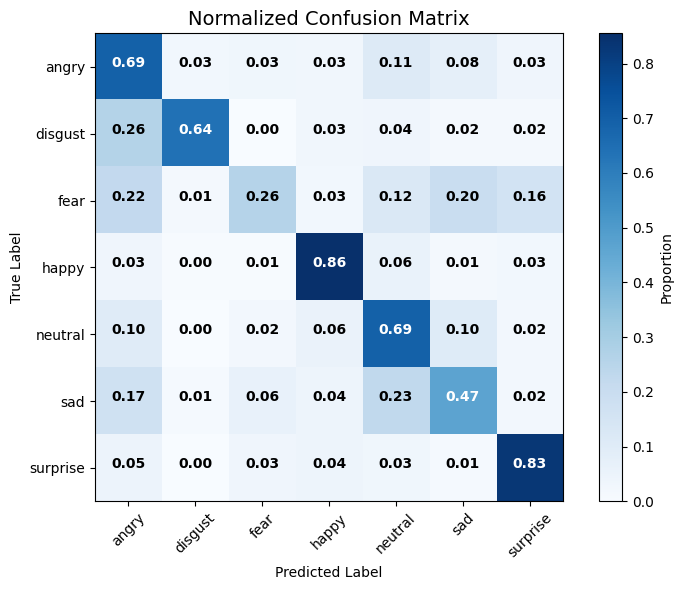

In [33]:
# ==========================================================
# ✅ Evaluate Model on Unseen Test Data (with Annotated Confusion Matrix)
# ==========================================================
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import matplotlib.pyplot as plt
import numpy as np

# Ensure generator order is consistent
test_gen.reset()

# Predict probabilities for each class
predictions = model.predict(test_gen, verbose=1)

# Get predicted class indices
y_pred = np.argmax(predictions, axis=1)

# True labels
y_true = test_gen.classes
class_labels = list(test_gen.class_indices.keys())

# Overall test accuracy
acc = accuracy_score(y_true, y_pred)
print(f"\n✅ Final Test Accuracy: {acc*100:.2f}%")

# Detailed classification report
report = classification_report(y_true, y_pred, target_names=class_labels)
print("\n📊 Classification Report:\n", report)

# Confusion matrix (normalized)
cm = confusion_matrix(y_true, y_pred, normalize='true')

plt.figure(figsize=(8,6))
plt.imshow(cm, interpolation='nearest', cmap='Blues')
plt.title('Normalized Confusion Matrix', fontsize=14)
plt.colorbar(label='Proportion')

tick_marks = np.arange(len(class_labels))
plt.xticks(tick_marks, class_labels, rotation=45)
plt.yticks(tick_marks, class_labels)

# Add text annotations (normalized values)
thresh = cm.max() / 2.
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, f"{cm[i, j]:.2f}",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black",
                 fontsize=10, weight='bold')

plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()


In [34]:
model.save('CNN_model.h5')

In [35]:
%pwd

'/content'

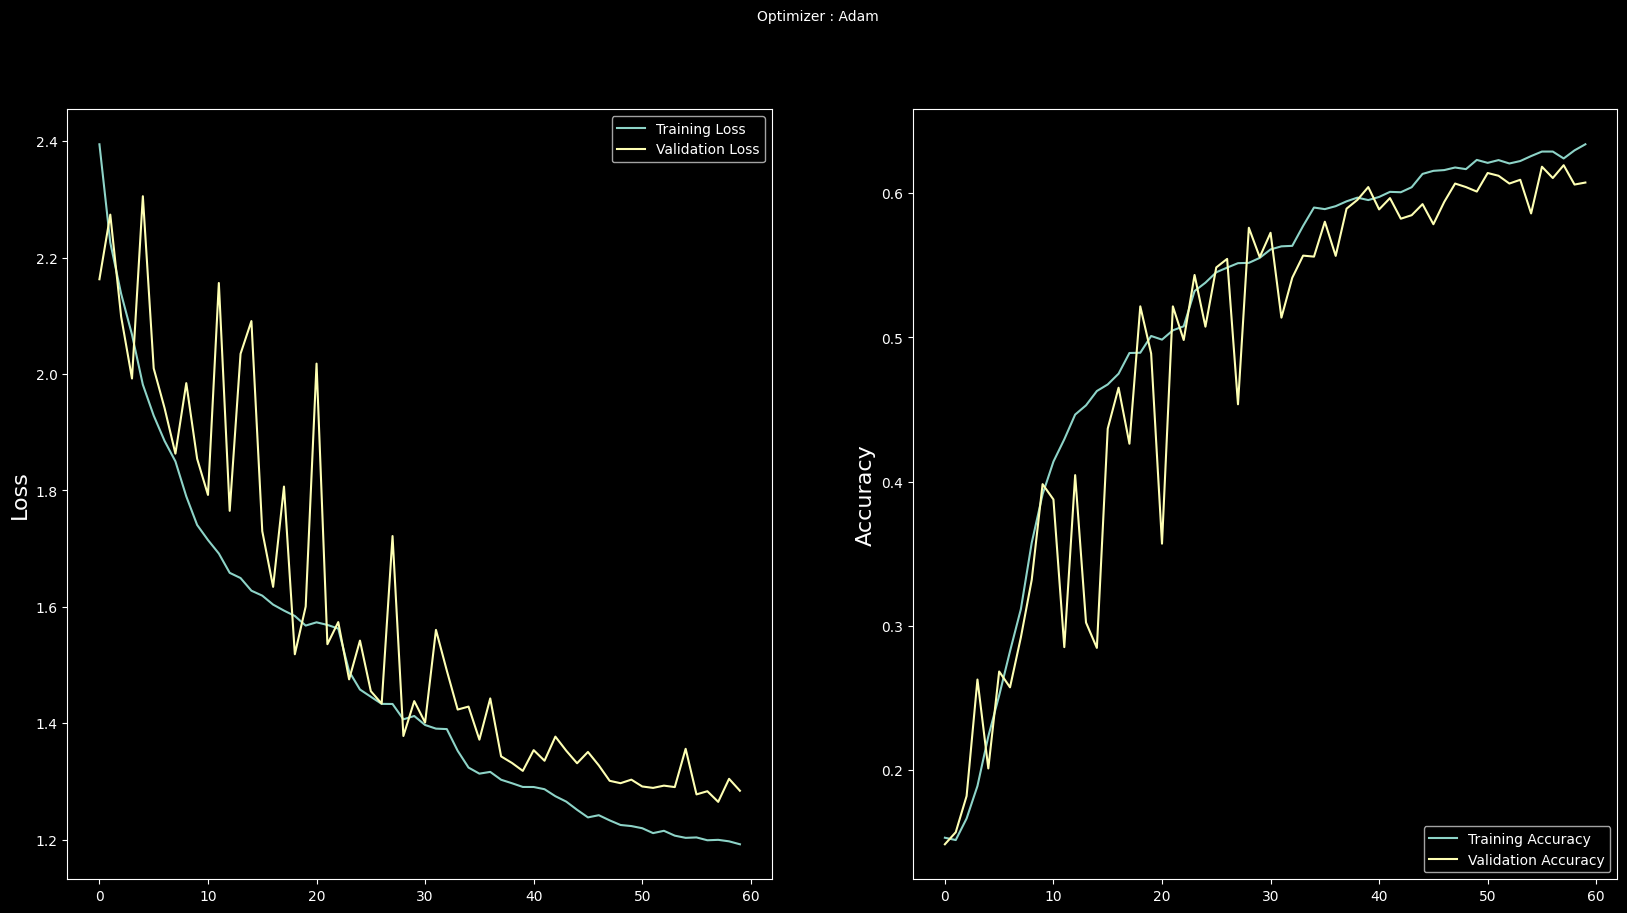

In [36]:
#Plotting Accuracy & Loss
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [38]:
!mkdir -p /content/drive/MyDrive/Emotion_Detection_Project
!cp /content/CNN_model.h5 /content/drive/MyDrive/Emotion_Detection_Project/CNN_model.h5


In [39]:
!ls "/content/drive/MyDrive/Emotion_Detection_Project"


CNN_model.h5


In [40]:
from tensorflow.keras.models import load_model
model = load_model('/content/drive/MyDrive/Emotion_Detection_Project/CNN_model.h5')
print("✅ Model loaded successfully!")


✅ Model loaded successfully!


In [41]:
from google.colab import files
uploaded = files.upload()

Saving Human1.jpg to Human1.jpg


Testing on: Human1.jpg
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


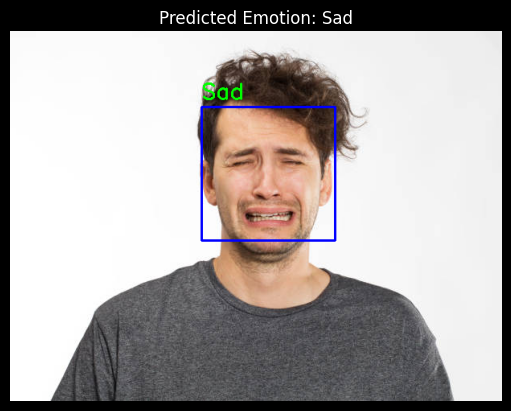

In [42]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load your trained model
model = load_model("/content/drive/MyDrive/Emotion_Detection_Project/CNN_model.h5")  # update path if needed
face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Emotion labels
emotion_labels = ['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']

# Path to uploaded image
img_path = list(uploaded.keys())[0]
print("Testing on:", img_path)

# Read and convert image
frame = cv2.imread(img_path)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

faces = face_classifier.detectMultiScale(gray, 1.3, 5)

for (x,y,w,h) in faces:
    roi_gray = gray[y:y+h, x:x+w]
    roi_gray = cv2.resize(roi_gray, (48,48), interpolation=cv2.INTER_AREA)

    roi = roi_gray.astype('float')/255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)

    prediction = model.predict(roi)[0]
    label = emotion_labels[prediction.argmax()]

    cv2.rectangle(frame, (x,y), (x+w,y+h), (255,0,0), 2)
    cv2.putText(frame, label, (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)

# Show output
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Predicted Emotion: {label}")
plt.show()

In [43]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
from PIL import Image
from io import BytesIO

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
      async function takePhoto(quality) {
        const div = document.createElement('div');
        const capture = document.createElement('button');
        capture.textContent = '📸 Take Photo';
        div.appendChild(capture);
        const video = document.createElement('video');
        video.style.display = 'block';
        const stream = await navigator.mediaDevices.getUserMedia({video: true});
        document.body.appendChild(div);
        div.appendChild(video);
        video.srcObject = stream;
        await video.play();

        // Resize the output to fit the video element.
        google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

        // Wait for capture
        await new Promise((resolve) => capture.onclick = resolve);

        const canvas = document.createElement('canvas');
        canvas.width = video.videoWidth;
        canvas.height = video.videoHeight;
        canvas.getContext('2d').drawImage(video, 0, 0);
        stream.getTracks().forEach(track => track.stop());
        div.remove();
        const dataUrl = canvas.toDataURL('image/jpeg', quality);
        return dataUrl;
      }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename


<IPython.core.display.Javascript object>

Saved to: photo.jpg


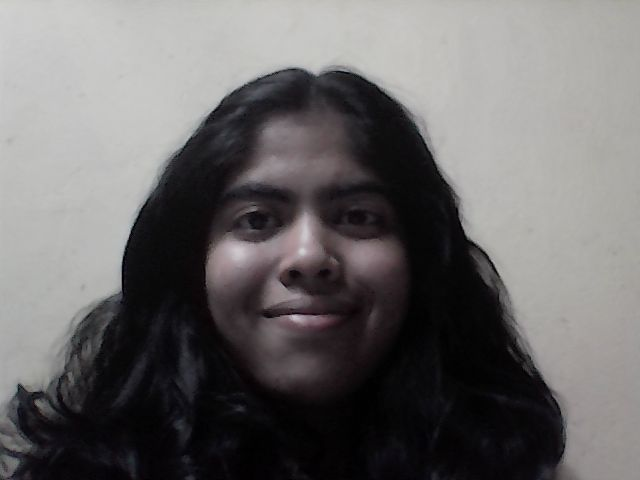

In [49]:
from IPython.display import Image as IPImage
try:
    filename = take_photo()
    print("Saved to:", filename)
    display(IPImage(filename))
except Exception as e:
    print("Error:", str(e))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


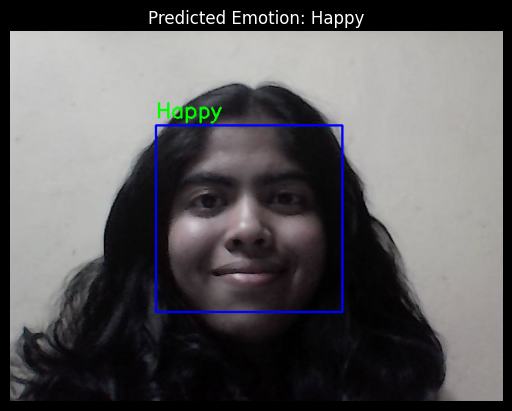

In [50]:
# Detect emotion from the captured photo
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array # Import img_to_array
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt

# Load your trained model (assuming it's already loaded in a previous cell or will be loaded here)
# model = load_model('/content/drive/MyDrive/Emotion_Detection_Project/CNN_model.h5') # Uncomment if model is not loaded elsewhere

face_classifier = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
emotion_labels = ['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']

frame = cv2.imread(filename)
gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
faces = face_classifier.detectMultiScale(gray, 1.3, 5)

for (x, y, w, h) in faces:
    roi_gray = gray[y:y+h, x:x+w]
    roi_gray = cv2.resize(roi_gray, (48,48), interpolation=cv2.INTER_AREA)
    roi = roi_gray.astype('float')/255.0
    roi = np.expand_dims(img_to_array(roi), axis=0)

    prediction = model.predict(roi)[0]
    label = emotion_labels[prediction.argmax()]
    cv2.rectangle(frame, (x,y), (x+w,y+h), (255,0,0), 2)
    cv2.putText(frame, label, (x,y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0,255,0), 2)

plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Predicted Emotion: {label}")
plt.show()